In [501]:
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from empath import Empath
import json
from scipy.spatial.distance import cdist

%matplotlib inline

nltk.download('stopwords')
nltk.download('vader_lexicon')

df = pd.read_csv('data_prep.csv')
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\breno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\breno\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,title,author,school,century,sentence_lowered,sentence_words_count,normalized_sentence,sentiment_score,lexical_categories
0,plato - complete works,plato,plato,-4,"what's new, socrates, to make you leave your ...",23,new socrates make leave usual haunts lyceum sp...,-0.2960,"{'family': 1.0, 'vacation': 1.0, 'leisure': 1...."
1,plato - complete works,plato,plato,-4,surely you are not prosecuting anyone before t...,13,surely prosecuting anyone king archon,0.4404,"{'royalty': 1.0, 'optimism': 1.0, 'medieval': ..."
2,plato - complete works,plato,plato,-4,the athenians do not call this a prosecution b...,12,athenians call prosecution indictment euthyphro,-0.3346,"{'crime': 1.0, 'dispute': 1.0, 'stealing': 1.0..."
3,plato - complete works,plato,plato,-4,what is this you say?,5,NaN,0.0000,{}
4,plato - complete works,plato,plato,-4,"someone must have indicted you, for you are no...",19,someone indicted going tell indicted someone else,0.0000,"{'communication': 1.0, 'order': 1.0, 'speaking..."
...,...,...,...,...,...,...,...,...,...
360779,"women, race, and class",davis,feminism,20,but the socialization of housework including m...,22,socialization housework including meal prepara...,0.8462,"{'help': 1.0, 'money': 1.0, 'domestic_work': 2..."
360780,"women, race, and class",davis,feminism,20,the only significant steps toward endingdomest...,17,significant steps toward endingdomestic slaver...,-0.6124,"{'crime': 1.0, 'dispute': 1.0, 'government': 1..."
360781,"women, race, and class",davis,feminism,20,"working women, therefore, have a special and v...",14,working women special vital interest struggle ...,0.6808,"{'occupation': 1.0, 'weakness': 1.0, 'leisure'..."
360782,"women, race, and class",davis,feminism,20,"moreover, under capitalism, campaigns for jobs...",28,moreover capitalism campaigns jobs equal basis...,0.4939,"{'family': 1.0, 'play': 1.0, 'heroic': 1.0, 'f..."


In [502]:
def add_categories(row, dictionary):
    row_dict = row['lexical_categories']
    row_dict = row_dict.replace('"', '%')
    row_dict = row_dict.replace("'", '"')
    row_dict = row_dict.replace("%", "'")
    row_dict = json.loads(row_dict)
    
    for key, value in row_dict.items():
        if key in dictionary:
            dictionary[key] += value
        else:
            dictionary[key] = value

In [503]:
dict_slice = 50
round_n = 5
school_list = {}

def get_categories_dict(school):
    df_school = df[df['school'] == school]
    school_dict = {}
    
    df_school.apply(add_categories, axis=1, args=(school_dict,))
    school_dict = dict(sorted(school_dict.items(), key=lambda item: item[1], reverse=True))

    n_words = df_school['sentence_words_count'].sum()

    for key, value in school_dict.items():
        school_dict[key] = round((value / n_words), round_n)

    school_dict= dict(list(school_dict.items())[:dict_slice])

    return school_dict

In [504]:
school_list['plato'] = get_categories_dict('plato')
school_list['plato']

{'speaking': 0.01102,
 'communication': 0.00758,
 'negative_emotion': 0.00601,
 'positive_emotion': 0.00473,
 'giving': 0.00464,
 'divine': 0.00433,
 'trust': 0.00422,
 'optimism': 0.0042,
 'children': 0.00396,
 'power': 0.00385,
 'listen': 0.00372,
 'dispute': 0.0037,
 'order': 0.00369,
 'hearing': 0.00351,
 'strength': 0.00335,
 'worship': 0.00333,
 'phone': 0.00302,
 'friends': 0.00295,
 'party': 0.00292,
 'philosophy': 0.00286,
 'violence': 0.00277,
 'masculine': 0.00275,
 'law': 0.00272,
 'love': 0.00262,
 'fight': 0.00255,
 'family': 0.00251,
 'school': 0.00249,
 'healing': 0.00248,
 'death': 0.00242,
 'emotional': 0.00241,
 'suffering': 0.00239,
 'achievement': 0.00238,
 'heroic': 0.00237,
 'leader': 0.00233,
 'traveling': 0.0022,
 'shape_and_size': 0.00217,
 'business': 0.00214,
 'music': 0.0021,
 'shame': 0.00209,
 'government': 0.00206,
 'help': 0.00204,
 'wedding': 0.00204,
 'pain': 0.00201,
 'religion': 0.00195,
 'movement': 0.00192,
 'stealing': 0.00189,
 'torment': 0.0018

In [505]:
school_list['aristotle'] = get_categories_dict('aristotle')
school_list['aristotle']

{'speaking': 0.0058,
 'negative_emotion': 0.00542,
 'positive_emotion': 0.00376,
 'shape_and_size': 0.00355,
 'trust': 0.00327,
 'movement': 0.00327,
 'strength': 0.00327,
 'masculine': 0.00313,
 'communication': 0.00308,
 'weather': 0.00304,
 'order': 0.00289,
 'warmth': 0.00283,
 'body': 0.00277,
 'children': 0.00265,
 'injury': 0.00264,
 'power': 0.00255,
 'school': 0.00247,
 'love': 0.00246,
 'dispute': 0.00231,
 'healing': 0.00229,
 'animal': 0.00213,
 'party': 0.00209,
 'confusion': 0.00207,
 'fire': 0.00203,
 'heroic': 0.002,
 'giving': 0.00199,
 'friends': 0.00198,
 'optimism': 0.00196,
 'cold': 0.00195,
 'divine': 0.00191,
 'appearance': 0.0019,
 'phone': 0.00186,
 'leader': 0.00186,
 'ocean': 0.00184,
 'liquid': 0.00184,
 'water': 0.00182,
 'emotional': 0.0018,
 'achievement': 0.00177,
 'cleaning': 0.00173,
 'philosophy': 0.00172,
 'violence': 0.00172,
 'college': 0.00171,
 'listen': 0.0017,
 'beach': 0.00169,
 'beauty': 0.00168,
 'sailing': 0.00167,
 'fight': 0.00164,
 'swim

In [506]:
school_list['empiricism'] = get_categories_dict('empiricism')
school_list['empiricism']

{'communication': 0.00632,
 'strength': 0.00568,
 'positive_emotion': 0.00557,
 'speaking': 0.00531,
 'negative_emotion': 0.00498,
 'power': 0.00493,
 'reading': 0.00431,
 'love': 0.00409,
 'trust': 0.00387,
 'order': 0.00378,
 'optimism': 0.00376,
 'leader': 0.00337,
 'philosophy': 0.00299,
 'giving': 0.00296,
 'masculine': 0.00293,
 'sadness': 0.00281,
 'dispute': 0.00277,
 'healing': 0.00276,
 'lust': 0.00272,
 'shape_and_size': 0.00263,
 'divine': 0.0026,
 'legend': 0.00253,
 'religion': 0.00246,
 'law': 0.00244,
 'worship': 0.00241,
 'contentment': 0.00236,
 'achievement': 0.00235,
 'fight': 0.00226,
 'government': 0.00223,
 'children': 0.0022,
 'traveling': 0.00219,
 'heroic': 0.00211,
 'party': 0.00204,
 'injury': 0.00198,
 'school': 0.00194,
 'body': 0.00191,
 'celebration': 0.00191,
 'cheerfulness': 0.00184,
 'beauty': 0.00184,
 'war': 0.00183,
 'shame': 0.00178,
 'movement': 0.00176,
 'military': 0.00176,
 'deception': 0.0017,
 'appearance': 0.00168,
 'disgust': 0.0016,
 'fri

In [507]:
school_list['rationalism'] = get_categories_dict('rationalism')
school_list['rationalism']

{'divine': 0.00877,
 'positive_emotion': 0.00729,
 'speaking': 0.00662,
 'communication': 0.00599,
 'worship': 0.00585,
 'trust': 0.00576,
 'order': 0.00526,
 'negative_emotion': 0.00524,
 'strength': 0.00512,
 'love': 0.00504,
 'optimism': 0.0049,
 'giving': 0.00441,
 'power': 0.00434,
 'healing': 0.00376,
 'leader': 0.00359,
 'philosophy': 0.00321,
 'injury': 0.00313,
 'reading': 0.00307,
 'lust': 0.00296,
 'sadness': 0.00288,
 'religion': 0.00284,
 'contentment': 0.00282,
 'friends': 0.0028,
 'body': 0.00268,
 'beauty': 0.00265,
 'shape_and_size': 0.00261,
 'dispute': 0.00257,
 'achievement': 0.00256,
 'deception': 0.00249,
 'legend': 0.00229,
 'torment': 0.00224,
 'traveling': 0.00221,
 'masculine': 0.00221,
 'shame': 0.00218,
 'cheerfulness': 0.00214,
 'children': 0.0021,
 'restaurant': 0.00207,
 'movement': 0.00205,
 'school': 0.00203,
 'affection': 0.002,
 'fear': 0.00198,
 'aggression': 0.00186,
 'sexual': 0.00182,
 'suffering': 0.00182,
 'pain': 0.0018,
 'fight': 0.00174,
 'an

In [508]:
school_list['analytic'] = get_categories_dict('analytic')
school_list['analytic']

{'speaking': 0.01384,
 'communication': 0.00876,
 'philosophy': 0.00553,
 'trust': 0.00517,
 'science': 0.00481,
 'school': 0.00425,
 'negative_emotion': 0.00408,
 'reading': 0.00402,
 'dispute': 0.0039,
 'strength': 0.00373,
 'positive_emotion': 0.00312,
 'college': 0.00307,
 'love': 0.003,
 'divine': 0.00293,
 'writing': 0.00287,
 'giving': 0.00273,
 'phone': 0.00254,
 'optimism': 0.00251,
 'party': 0.00241,
 'religion': 0.00232,
 'fear': 0.0023,
 'meeting': 0.00227,
 'order': 0.00226,
 'listen': 0.00218,
 'hearing': 0.00216,
 'power': 0.00212,
 'celebration': 0.00208,
 'deception': 0.002,
 'shape_and_size': 0.00199,
 'confusion': 0.00194,
 'leader': 0.00193,
 'heroic': 0.00172,
 'children': 0.00167,
 'journalism': 0.00164,
 'appearance': 0.00156,
 'emotional': 0.00153,
 'music': 0.0015,
 'work': 0.00147,
 'stealing': 0.00146,
 'traveling': 0.00141,
 'violence': 0.0014,
 'law': 0.00139,
 'worship': 0.00135,
 'shame': 0.00134,
 'business': 0.00134,
 'lust': 0.00133,
 'technology': 0.0

In [509]:
school_list['continental'] = get_categories_dict('continental')
school_list['continental']

{'speaking': 0.00635,
 'communication': 0.00485,
 'philosophy': 0.00431,
 'negative_emotion': 0.0041,
 'shape_and_size': 0.00389,
 'sadness': 0.00367,
 'giving': 0.0035,
 'school': 0.00347,
 'science': 0.00342,
 'health': 0.00342,
 'love': 0.0034,
 'reading': 0.00334,
 'legend': 0.0033,
 'suffering': 0.0033,
 'leader': 0.00323,
 'fear': 0.00317,
 'positive_emotion': 0.00315,
 'religion': 0.00314,
 'strength': 0.00311,
 'medical_emergency': 0.00308,
 'power': 0.00307,
 'trust': 0.00296,
 'order': 0.00283,
 'healing': 0.00275,
 'divine': 0.00269,
 'optimism': 0.00269,
 'government': 0.00266,
 'business': 0.00256,
 'anger': 0.00238,
 'rage': 0.00232,
 'economics': 0.00231,
 'disgust': 0.00225,
 'heroic': 0.00219,
 'children': 0.00216,
 'law': 0.00213,
 'lust': 0.00209,
 'musical': 0.00208,
 'journalism': 0.00207,
 'music': 0.00205,
 'college': 0.00201,
 'dispute': 0.00201,
 'worship': 0.002,
 'achievement': 0.00195,
 'war': 0.00193,
 'movement': 0.0019,
 'sexual': 0.0019,
 'ancient': 0.00

In [510]:
school_list['phenomenology'] = get_categories_dict('phenomenology')
school_list['phenomenology']

{'speaking': 0.00829,
 'communication': 0.00681,
 'philosophy': 0.00606,
 'trust': 0.00541,
 'school': 0.00504,
 'science': 0.00495,
 'love': 0.00437,
 'positive_emotion': 0.00432,
 'negative_emotion': 0.00414,
 'legend': 0.00363,
 'optimism': 0.00313,
 'religion': 0.00301,
 'college': 0.00282,
 'power': 0.00267,
 'shape_and_size': 0.0026,
 'party': 0.00259,
 'body': 0.00254,
 'divine': 0.00252,
 'giving': 0.00248,
 'heroic': 0.00243,
 'strength': 0.00223,
 'business': 0.00221,
 'children': 0.00221,
 'healing': 0.00217,
 'fear': 0.00207,
 'celebration': 0.00202,
 'reading': 0.00199,
 'leader': 0.00199,
 'dispute': 0.00198,
 'order': 0.00197,
 'death': 0.00192,
 'contentment': 0.00189,
 'work': 0.00189,
 'sympathy': 0.00187,
 'confusion': 0.00181,
 'movement': 0.00179,
 'friends': 0.00177,
 'lust': 0.00177,
 'politeness': 0.00168,
 'achievement': 0.00166,
 'traveling': 0.00165,
 'phone': 0.00159,
 'listen': 0.00157,
 'independence': 0.00153,
 'emotional': 0.00152,
 'ancient': 0.0015,
 '

In [511]:
school_list['german_idealism'] = get_categories_dict('german_idealism')
school_list['german_idealism']

{'positive_emotion': 0.00702,
 'strength': 0.00499,
 'religion': 0.00497,
 'love': 0.00496,
 'philosophy': 0.00489,
 'trust': 0.00472,
 'power': 0.00444,
 'negative_emotion': 0.00426,
 'lust': 0.00415,
 'law': 0.00406,
 'communication': 0.00401,
 'speaking': 0.00378,
 'optimism': 0.00371,
 'dispute': 0.00368,
 'school': 0.00367,
 'contentment': 0.00355,
 'divine': 0.00349,
 'government': 0.00344,
 'order': 0.00325,
 'achievement': 0.00307,
 'leader': 0.00307,
 'shape_and_size': 0.00293,
 'science': 0.00284,
 'pride': 0.00271,
 'worship': 0.0026,
 'beauty': 0.00244,
 'giving': 0.00242,
 'heroic': 0.00238,
 'shame': 0.00238,
 'college': 0.00222,
 'cheerfulness': 0.00222,
 'zest': 0.0022,
 'independence': 0.00218,
 'traveling': 0.00196,
 'healing': 0.00188,
 'stealing': 0.00187,
 'party': 0.00187,
 'reading': 0.00184,
 'legend': 0.00179,
 'fashion': 0.00174,
 'military': 0.00173,
 'work': 0.00171,
 'sympathy': 0.00161,
 'sadness': 0.0016,
 'crime': 0.00156,
 'gain': 0.00154,
 'business': 

In [512]:
school_list['communism'] = get_categories_dict('communism')
school_list['communism']

{'economics': 0.01452,
 'business': 0.01242,
 'valuable': 0.01072,
 'government': 0.00733,
 'money': 0.00708,
 'work': 0.00591,
 'banking': 0.00526,
 'gain': 0.00473,
 'shape_and_size': 0.00449,
 'payment': 0.00445,
 'politics': 0.00443,
 'negotiate': 0.00441,
 'power': 0.00413,
 'law': 0.00394,
 'communication': 0.00379,
 'leader': 0.00378,
 'school': 0.00375,
 'giving': 0.00355,
 'speaking': 0.00351,
 'real_estate': 0.0035,
 'science': 0.00348,
 'strength': 0.00345,
 'shopping': 0.0034,
 'occupation': 0.00338,
 'war': 0.00291,
 'reading': 0.00285,
 'military': 0.00271,
 'healing': 0.00266,
 'dispute': 0.00264,
 'legend': 0.00263,
 'order': 0.00256,
 'positive_emotion': 0.00256,
 'musical': 0.00253,
 'wealthy': 0.00247,
 'meeting': 0.00247,
 'college': 0.00245,
 'independence': 0.00235,
 'achievement': 0.00234,
 'negative_emotion': 0.00232,
 'movement': 0.00225,
 'philosophy': 0.00224,
 'technology': 0.00221,
 'fight': 0.00216,
 'party': 0.00213,
 'dominant_heirarchical': 0.00211,
 'f

In [513]:
school_list['capitalism'] = get_categories_dict('capitalism')
school_list['capitalism']

{'economics': 0.02262,
 'money': 0.01977,
 'valuable': 0.01722,
 'payment': 0.01545,
 'banking': 0.01401,
 'business': 0.01174,
 'negotiate': 0.00897,
 'real_estate': 0.00821,
 'shopping': 0.0077,
 'giving': 0.00568,
 'gain': 0.00551,
 'wealthy': 0.0051,
 'positive_emotion': 0.00448,
 'strength': 0.00441,
 'achievement': 0.00439,
 'government': 0.00438,
 'power': 0.00384,
 'law': 0.00368,
 'order': 0.00357,
 'leader': 0.00349,
 'work': 0.00323,
 'negative_emotion': 0.00297,
 'poor': 0.00289,
 'home': 0.00236,
 'love': 0.00233,
 'military': 0.00231,
 'celebration': 0.0023,
 'school': 0.0023,
 'shape_and_size': 0.00225,
 'optimism': 0.00219,
 'farming': 0.00218,
 'heroic': 0.00216,
 'traveling': 0.00213,
 'lust': 0.00207,
 'speaking': 0.00204,
 'politics': 0.00203,
 'leisure': 0.00203,
 'occupation': 0.00192,
 'college': 0.00192,
 'help': 0.0019,
 'movement': 0.00188,
 'science': 0.00186,
 'royalty': 0.00184,
 'communication': 0.00174,
 'healing': 0.00174,
 'party': 0.00174,
 'friends': 

In [514]:
school_list['stoicism'] = get_categories_dict('stoicism')
school_list['stoicism']

{'negative_emotion': 0.01009,
 'positive_emotion': 0.00657,
 'trust': 0.00499,
 'speaking': 0.00455,
 'divine': 0.00404,
 'strength': 0.00401,
 'suffering': 0.00374,
 'beauty': 0.00358,
 'children': 0.00351,
 'death': 0.00343,
 'masculine': 0.00332,
 'optimism': 0.0033,
 'sadness': 0.00313,
 'healing': 0.0031,
 'love': 0.00293,
 'injury': 0.00288,
 'pain': 0.0028,
 'power': 0.00279,
 'communication': 0.00266,
 'violence': 0.00263,
 'emotional': 0.00246,
 'shame': 0.00244,
 'giving': 0.00244,
 'worship': 0.00238,
 'order': 0.0023,
 'party': 0.00224,
 'achievement': 0.00221,
 'torment': 0.00205,
 'art': 0.00197,
 'religion': 0.00196,
 'celebration': 0.00194,
 'breaking': 0.00189,
 'cheerfulness': 0.00189,
 'leader': 0.00188,
 'hate': 0.00182,
 'friends': 0.00174,
 'magic': 0.00171,
 'heroic': 0.00169,
 'affection': 0.00167,
 'traveling': 0.00164,
 'lust': 0.0016,
 'kill': 0.00158,
 'hearing': 0.00156,
 'politeness': 0.00156,
 'listen': 0.00155,
 'family': 0.00153,
 'childish': 0.00153,
 

In [515]:
school_list['nietzsche'] = get_categories_dict('nietzsche')
school_list['nietzsche']

{'positive_emotion': 0.00749,
 'divine': 0.00745,
 'worship': 0.0071,
 'speaking': 0.00634,
 'religion': 0.00557,
 'negative_emotion': 0.00545,
 'communication': 0.00514,
 'optimism': 0.00495,
 'sadness': 0.00493,
 'philosophy': 0.0047,
 'love': 0.00455,
 'suffering': 0.00392,
 'achievement': 0.0036,
 'death': 0.00347,
 'strength': 0.00342,
 'shame': 0.00335,
 'power': 0.00333,
 'affection': 0.00329,
 'masculine': 0.00326,
 'listen': 0.00316,
 'hate': 0.00307,
 'friends': 0.00304,
 'giving': 0.00301,
 'heroic': 0.003,
 'trust': 0.00299,
 'pain': 0.00294,
 'children': 0.00283,
 'order': 0.00282,
 'hearing': 0.00282,
 'aggression': 0.00256,
 'contentment': 0.00253,
 'law': 0.00251,
 'body': 0.00245,
 'violence': 0.00241,
 'deception': 0.00241,
 'leader': 0.00239,
 'party': 0.00236,
 'dispute': 0.00235,
 'kill': 0.0023,
 'emotional': 0.00227,
 'anger': 0.00225,
 'school': 0.00223,
 'fear': 0.00223,
 'shape_and_size': 0.0022,
 'disgust': 0.00218,
 'phone': 0.00218,
 'art': 0.00217,
 'lust'

In [516]:
school_list['feminism'] = get_categories_dict('feminism')
school_list['feminism']

{'children': 0.01322,
 'feminine': 0.00701,
 'positive_emotion': 0.00692,
 'family': 0.0064,
 'love': 0.00631,
 'appearance': 0.00601,
 'sexual': 0.0052,
 'masculine': 0.00506,
 'negative_emotion': 0.00503,
 'optimism': 0.00467,
 'friends': 0.00466,
 'wedding': 0.00414,
 'power': 0.00381,
 'youth': 0.00368,
 'speaking': 0.00356,
 'affection': 0.00356,
 'strength': 0.00351,
 'sadness': 0.00346,
 'lust': 0.00345,
 'giving': 0.00337,
 'divine': 0.00328,
 'death': 0.00327,
 'childish': 0.00326,
 'communication': 0.00322,
 'home': 0.00313,
 'religion': 0.00311,
 'trust': 0.00311,
 'achievement': 0.00294,
 'worship': 0.00292,
 'suffering': 0.00282,
 'violence': 0.00276,
 'government': 0.00273,
 'law': 0.00272,
 'leader': 0.0027,
 'contentment': 0.00263,
 'aggression': 0.00263,
 'dispute': 0.0026,
 'business': 0.0026,
 'party': 0.00257,
 'school': 0.00252,
 'shape_and_size': 0.00249,
 'pain': 0.00247,
 'fight': 0.00247,
 'shame': 0.00245,
 'heroic': 0.00239,
 'hate': 0.00236,
 'body': 0.00234

In [517]:
all_dicts = {**school_list['plato'], **school_list['aristotle'], **school_list['empiricism'], **school_list['rationalism'], **school_list['analytic'], **school_list['continental'], **school_list['phenomenology'], **school_list['german_idealism'], **school_list['communism'], **school_list['capitalism'], **school_list['stoicism'], **school_list['nietzsche'], **school_list['feminism']}
all_dicts

{'speaking': 0.00356,
 'communication': 0.00322,
 'negative_emotion': 0.00503,
 'positive_emotion': 0.00692,
 'giving': 0.00337,
 'divine': 0.00328,
 'trust': 0.00311,
 'optimism': 0.00467,
 'children': 0.01322,
 'power': 0.00381,
 'listen': 0.00316,
 'dispute': 0.0026,
 'order': 0.00225,
 'hearing': 0.00282,
 'strength': 0.00351,
 'worship': 0.00292,
 'phone': 0.00218,
 'friends': 0.00466,
 'party': 0.00257,
 'philosophy': 0.0047,
 'violence': 0.00276,
 'masculine': 0.00506,
 'law': 0.00272,
 'love': 0.00631,
 'fight': 0.00247,
 'family': 0.0064,
 'school': 0.00252,
 'healing': 0.0031,
 'death': 0.00327,
 'emotional': 0.00227,
 'suffering': 0.00282,
 'achievement': 0.00294,
 'heroic': 0.00239,
 'leader': 0.0027,
 'traveling': 0.00164,
 'shape_and_size': 0.00249,
 'business': 0.0026,
 'music': 0.00205,
 'shame': 0.00245,
 'government': 0.00273,
 'help': 0.0019,
 'wedding': 0.00414,
 'pain': 0.00247,
 'religion': 0.00311,
 'movement': 0.00188,
 'stealing': 0.00187,
 'torment': 0.00215,


In [518]:
len(all_dicts)

130

In [519]:
schools = df['school'].unique()
schools

array(['plato', 'aristotle', 'empiricism', 'rationalism', 'analytic',
       'continental', 'phenomenology', 'german_idealism', 'communism',
       'capitalism', 'stoicism', 'nietzsche', 'feminism'], dtype=object)

In [520]:
df_schools = df.groupby('school')['sentiment_score'].mean()
df_schools = pd.DataFrame(df_schools)
df_schools['sentiment_score'] = df_schools['sentiment_score'].apply(lambda x: (x + 1) / 2)
df_schools = df_schools.drop('sentiment_score', axis=1)
df_schools

""
school
analytic
aristotle
capitalism
communism
continental
empiricism
feminism
german_idealism
nietzsche


In [521]:
for key in all_dicts.keys():
    df_schools[key] = 0

df_schools

C:\Users\breno\AppData\Local\Temp\ipykernel_9024\2680347201.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_schools[key] = 0
C:\Users\breno\AppData\Local\Temp\ipykernel_9024\2680347201.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_schools[key] = 0
C:\Users\breno\AppData\Local\Temp\ipykernel_9024\2680347201.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

,speaking,communication,negative_emotion,positive_emotion,giving,divine,trust,optimism,children,power,...,leisure,eating,art,breaking,hate,kill,childish,feminine,youth,attractive
school,,,,,,,,,,,,,,,,,,,,,
analytic,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aristotle,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
capitalism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
communism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
continental,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
empiricism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
feminism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
german_idealism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nietzsche,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [522]:
for school in school_list.keys():
    for key, value in school_list[school].items():
        df_schools.loc[school, key] = value
        
df_schools

,speaking,communication,negative_emotion,positive_emotion,giving,divine,trust,optimism,children,power,...,leisure,eating,art,breaking,hate,kill,childish,feminine,youth,attractive
school,,,,,,,,,,,,,,,,,,,,,
analytic,0.01384,0.00876,0.00408,0.00312,0.00273,0.00293,0.00517,0.00251,0.00167,0.00212,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
aristotle,0.00580,0.00308,0.00542,0.00376,0.00199,0.00191,0.00327,0.00196,0.00265,0.00255,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
capitalism,0.00204,0.00174,0.00297,0.00448,0.00568,0.00000,0.00000,0.00219,0.00000,0.00384,...,0.00203,0.00169,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
communism,0.00351,0.00379,0.00232,0.00256,0.00355,0.00000,0.00000,0.00000,0.00000,0.00413,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
continental,0.00635,0.00485,0.00410,0.00315,0.00350,0.00269,0.00296,0.00269,0.00216,0.00307,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
empiricism,0.00531,0.00632,0.00498,0.00557,0.00296,0.00260,0.00387,0.00376,0.00220,0.00493,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
feminism,0.00356,0.00322,0.00503,0.00692,0.00337,0.00328,0.00311,0.00467,0.01322,0.00381,...,0.00000,0.00000,0.00000,0.00000,0.00236,0.00000,0.00326,0.00701,0.00368,0.00229
german_idealism,0.00378,0.00401,0.00426,0.00702,0.00242,0.00349,0.00472,0.00371,0.00000,0.00444,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
nietzsche,0.00634,0.00514,0.00545,0.00749,0.00301,0.00745,0.00299,0.00495,0.00283,0.00333,...,0.00000,0.00000,0.00217,0.00000,0.00307,0.00230,0.00000,0.00000,0.00000,0.00000


In [523]:
distances = cdist(df_schools.values, df_schools.values, metric='euclidean')
df_distances = pd.DataFrame(distances, columns=df_schools.index, index=df_schools.index)
df_distances

school,analytic,aristotle,capitalism,communism,continental,empiricism,feminism,german_idealism,nietzsche,phenomenology,plato,rationalism,stoicism
school,,,,,,,,,,,,,
analytic,0.000000,0.018031,0.050046,0.032849,0.015952,0.016826,0.028416,0.018425,0.020912,0.011664,0.015031,0.019698,0.021802
aristotle,0.018031,0.000000,0.048252,0.032269,0.017138,0.014932,0.024208,0.018667,0.020063,0.015674,0.016069,0.018482,0.016166
capitalism,0.050046,0.048252,0.000000,0.026725,0.046879,0.047973,0.051558,0.047612,0.050884,0.048467,0.049046,0.049956,0.049240
communism,0.032849,0.032269,0.026725,0.000000,0.029062,0.031403,0.038112,0.030730,0.036611,0.031152,0.033056,0.035309,0.035094
continental,0.015952,0.017138,0.046879,0.029062,0.000000,0.013968,0.025034,0.015424,0.018606,0.013739,0.017282,0.017334,0.019220
empiricism,0.016826,0.014932,0.047973,0.031403,0.013968,0.000000,0.022052,0.012271,0.016175,0.014303,0.015331,0.011188,0.015421
feminism,0.028416,0.024208,0.051558,0.038112,0.025034,0.022052,0.000000,0.025250,0.022433,0.025627,0.022765,0.023664,0.021730
german_idealism,0.018425,0.018667,0.047612,0.030730,0.015424,0.012271,0.025250,0.000000,0.018390,0.014607,0.018446,0.015492,0.018617
nietzsche,0.020912,0.020063,0.050884,0.036611,0.018606,0.016175,0.022433,0.018390,0.000000,0.018538,0.016025,0.014068,0.015765


In [524]:
data = []

for row_key, row_data in df_distances.iterrows():
    for col_key, distance in row_data.items():
        data.append((row_key, col_key, distance))

df_flat = pd.DataFrame(data, columns=['school1', 'school2', 'distance'])
df_flat = df_flat[df_flat['distance'] != 0]
df_flat

,school1,school2,distance
1,analytic,aristotle,0.018031
2,analytic,capitalism,0.050046
3,analytic,communism,0.032849
4,analytic,continental,0.015952
5,analytic,empiricism,0.016826
...,...,...,...
163,stoicism,german_idealism,0.018617
164,stoicism,nietzsche,0.015765
165,stoicism,phenomenology,0.018734
166,stoicism,plato,0.016345


In [525]:
top_combinations = df_flat.groupby('school1').apply(lambda x: x.nsmallest(5, 'distance'))
top_combinations.reset_index(drop=True, inplace=True)
top_combinations

,school1,school2,distance
0,analytic,phenomenology,0.011664
1,analytic,plato,0.015031
2,analytic,continental,0.015952
3,analytic,empiricism,0.016826
4,analytic,aristotle,0.018031
...,...,...,...
60,stoicism,empiricism,0.015421
61,stoicism,nietzsche,0.015765
62,stoicism,aristotle,0.016166
63,stoicism,rationalism,0.016192


In [526]:
df_cent = df.groupby('school')['century'].mean()
df_cent

school
analytic           20.000000
aristotle          -4.000000
capitalism         18.544795
communism          19.000000
continental        20.000000
empiricism         17.554217
feminism           19.725356
german_idealism    18.538770
nietzsche          19.000000
phenomenology      20.000000
plato              -4.000000
rationalism        17.219089
stoicism            2.000000
Name: century, dtype: float64

In [537]:
sorted_df = top_combinations.sort_values(['school1', 'distance'], ascending=[True, True])
sorted_df

,school1,school2,distance
0,analytic,phenomenology,0.011664
1,analytic,plato,0.015031
2,analytic,continental,0.015952
3,analytic,empiricism,0.016826
4,analytic,aristotle,0.018031
...,...,...,...
60,stoicism,empiricism,0.015421
61,stoicism,nietzsche,0.015765
62,stoicism,aristotle,0.016166
63,stoicism,rationalism,0.016192


In [538]:
sorted_df.to_csv('sorted_data.csv', index=False)

In [532]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)

kmeans.fit(df_schools)

labels = kmeans.labels_

df_schools['cluster'] = labels

df_schools['cluster']

school
analytic           1
aristotle          1
capitalism         4
communism          3
continental        1
empiricism         0
feminism           5
german_idealism    0
nietzsche          2
phenomenology      1
plato              1
rationalism        0
stoicism           2
Name: cluster, dtype: int32

In [533]:
df_dendro = df_schools.drop('cluster', axis=1)
df_dendro

,speaking,communication,negative_emotion,positive_emotion,giving,divine,trust,optimism,children,power,...,leisure,eating,art,breaking,hate,kill,childish,feminine,youth,attractive
school,,,,,,,,,,,,,,,,,,,,,
analytic,0.01384,0.00876,0.00408,0.00312,0.00273,0.00293,0.00517,0.00251,0.00167,0.00212,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
aristotle,0.00580,0.00308,0.00542,0.00376,0.00199,0.00191,0.00327,0.00196,0.00265,0.00255,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
capitalism,0.00204,0.00174,0.00297,0.00448,0.00568,0.00000,0.00000,0.00219,0.00000,0.00384,...,0.00203,0.00169,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
communism,0.00351,0.00379,0.00232,0.00256,0.00355,0.00000,0.00000,0.00000,0.00000,0.00413,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
continental,0.00635,0.00485,0.00410,0.00315,0.00350,0.00269,0.00296,0.00269,0.00216,0.00307,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
empiricism,0.00531,0.00632,0.00498,0.00557,0.00296,0.00260,0.00387,0.00376,0.00220,0.00493,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
feminism,0.00356,0.00322,0.00503,0.00692,0.00337,0.00328,0.00311,0.00467,0.01322,0.00381,...,0.00000,0.00000,0.00000,0.00000,0.00236,0.00000,0.00326,0.00701,0.00368,0.00229
german_idealism,0.00378,0.00401,0.00426,0.00702,0.00242,0.00349,0.00472,0.00371,0.00000,0.00444,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
nietzsche,0.00634,0.00514,0.00545,0.00749,0.00301,0.00745,0.00299,0.00495,0.00283,0.00333,...,0.00000,0.00000,0.00217,0.00000,0.00307,0.00230,0.00000,0.00000,0.00000,0.00000


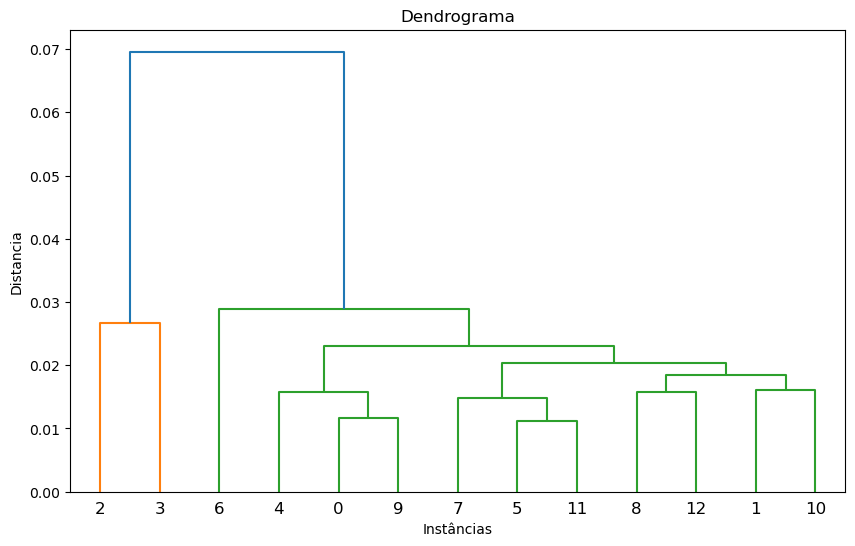

In [536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming your DataFrame is named 'df' containing only numeric variables

# Perform hierarchical clustering
Z = linkage(df_dendro, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.xlabel('Instâncias')
plt.ylabel('Distancia')
plt.title('Dendrograma')
plt.show()